In [1226]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [1227]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [1228]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [1229]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [1230]:
class NeumannBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [1231]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [1250]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    rows[0] = 0
    cols[0] = 0
    if ncv > 1:
        data[1] = coeffs.aE[0]
        rows[1] = 0
        cols[1] = 1

    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
        
    if ncv > 1:
        data[3*ncv-4] = coeffs.aW[-1]
        data[3*ncv-3] = coeffs.aP[-1]
        rows[3*ncv-4:3*ncv-2] = ncv-1
        cols[3*ncv-4] = ncv-2
        cols[3*ncv-3] = ncv-1
        
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [1257]:
#Problem 1
# For ncv 1
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 1
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T1 = T
    xP1 = grid.xP

Iteration = 0; Max. Resid. = 2.9999999999999996; Avg. Resid. = 2.9999999999999996
[373. 323. 273.]
Iteration = 1; Max. Resid. = 0.0; Avg. Resid. = 0.0


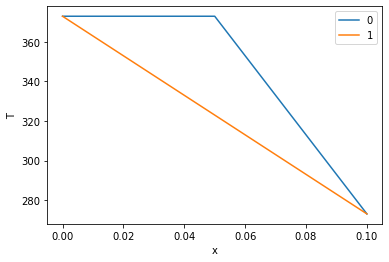

In [1258]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [1259]:
#Problem 1
#Grid 2
# For ncv 2
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 2
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T2 = T
    xP2 = grid.xP

Iteration = 0; Max. Resid. = 6.000000000000001; Avg. Resid. = 3.0000000000000004
[373. 348. 298. 273.]
Iteration = 1; Max. Resid. = 6.661338147750939e-16; Avg. Resid. = 4.440892098500626e-16


In [1260]:
#Problem 1
#Grid 3
# For ncv 4
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 4
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T3 = T
    xP3 = grid.xP

Iteration = 0; Max. Resid. = 12.000000000000002; Avg. Resid. = 3.0000000000000004
[373.  360.5 335.5 310.5 285.5 273. ]
Iteration = 1; Max. Resid. = 6.661338147750939e-16; Avg. Resid. = 5.551115123125783e-16


In [1261]:
#Problem 1
#Grid 4
# For ncv 8
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
'''
The temperature is fixed on both sides of the bar. 
Therefore, Dirichelet Boundary conditions were applied on both west and east boundary location
'''
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)   
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    #Saving the temperatures in an array for grid independence test
    T4 = T
    xP4 = grid.xP

Iteration = 0; Max. Resid. = 23.99999999999998; Avg. Resid. = 2.9999999999999973
[373.   366.75 354.25 341.75 329.25 316.75 304.25 291.75 279.25 273.  ]
Iteration = 1; Max. Resid. = 3.3306690738754696e-15; Avg. Resid. = 1.304512053934559e-15


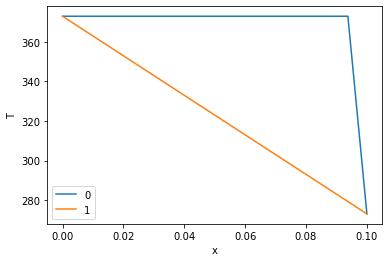

In [1269]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

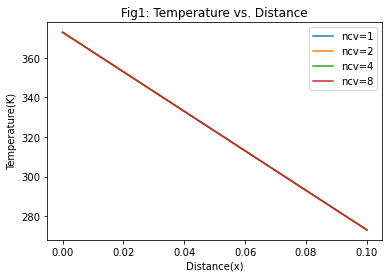

In [1265]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xP1, T1, label='ncv=1')
plt.plot(xP2, T2, label='ncv=2')
plt.plot(xP3, T3, label='ncv=4')
plt.plot(xP4, T4, label='ncv=8')
plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()
#Display the title
plt.title('Fig1: Temperature vs. Distance')
plt.show()


In [1268]:
#Explanation of Result:
'''
The Steady state heat conduction with heat generation (d/dt = 0 and egen = 0) is 
                        d^2T/dx^2 = 0
After Integrating twice, the temperature profile becomes:
                        T = ax + b
                where a and b are arbitary constants.
                
As the equation of T is a linear, the temperature profile shown in Figure1 is also linear.
For 273K temperature at the west boundary and 373K temperature at the east boundary,
the temperature profile varies from 373 to 273.
'''
#Explanation for Grid Indepence Test:
'''
In figure1, the temperature profile has been printed for number of control volume(ncv) 1,2,4 and 8.
It is visible from the graph that problem converges even for 1 ncv for a thermal conduction problem
with no heat generation. The problem converges only after one iteration as it is a liner profile temperature problem.
'''


'\nIn figure1, the temperature profile has been printed for number of control volume(ncv) 1,2,4 and 8.\nIt is visible from the graph that problem converges even for 1 ncv for a thermal conduction problem\nwith no heat generation. The problem converges only after one iteration as it is a liner profile temperature problem.\n'

In [ ]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
      
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs
    

In [1293]:
# Problem 2
# Grid Independence Study
# Grid 1 for ncv 4
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 4
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

#Calculating the avg temperature for Grid Indepedence test:
avg1 = np.mean(T)
print('Average Temp for ncv = 1 is ', avg1)

#Saving the solution for grid indepence test   
T1 = T
xP1 = grid.xP

Iteration = 0; Max. Resid. = 0.45; Avg. Resid. = 0.45
[373.         366.46473029 360.2406639  360.2406639  366.46473029
 373.        ]
Iteration = 1; Max. Resid. = 1.27675647831893e-15; Avg. Resid. = 1.0269562977782698e-15
Average Temp for ncv = 1 is  366.5684647302904


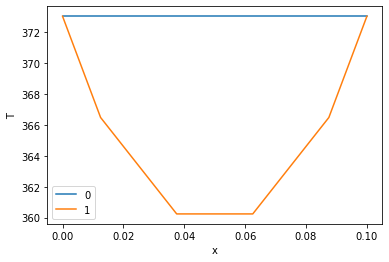

In [1294]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()



In [1295]:
# Problem 2 
#Grid 2 for ncv 8
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

#Calculating the avg temperature for Grid Indepedence test:
avg2 = np.mean(T)
print('Average Temp for ncv = 2 is ', avg2)    
    
#Storing the solution for grid independence test   
T2 = T
xP2 = grid.xP

Iteration = 0; Max. Resid. = 0.225; Avg. Resid. = 0.225
[373.         369.69413636 364.8747625  361.7272577  360.17293434
 360.17293434 361.7272577  364.8747625  369.69413636 373.        ]
Iteration = 1; Max. Resid. = 1.1324274851176597e-14; Avg. Resid. = 4.107825191113079e-15
Average Temp for ncv = 2 is  365.8938181807584


In [1296]:
# Problem 2
# Grid 3 for ncv = 16
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 16
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg3 = np.mean(T)
print('Average Temp for ncv = 3 is ', avg3)


#Storing the solution fo grid indepence test
T3 = T
xP3 = grid.xP

Iteration = 0; Max. Resid. = 0.1125; Avg. Resid. = 0.1125
[373.         371.34220263 368.48499666 366.06832192 364.07707419
 362.49880818 361.32365972 360.54428413 360.15581031 360.15581031
 360.54428413 361.32365972 362.49880818 364.07707419 366.06832192
 368.48499666 371.34220263 373.        ]
Iteration = 1; Max. Resid. = 1.3655743202889425e-14; Avg. Resid. = 7.232062171347309e-15
Average Temp for ncv = 3 is  365.27723974926914


In [1297]:
# Problem 2
# Grid 4 for ncv = 32
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg4 = np.mean(T)
print('Average Temp for ncv = 4 is ', avg4)
    
#Storing the solution for grid indepence test
T4 = T
xP4 = grid.xP

Iteration = 0; Max. Resid. = 0.05625; Avg. Resid. = 0.05625
[373.         372.17049035 370.62736244 369.19771478 367.87931355
 366.67009875 365.56818098 364.57183849 363.6795145  362.88981475
 362.20150533 361.61351077 361.12491232 360.73494654 360.44300412
 360.24862889 360.15151715 360.15151715 360.24862889 360.44300412
 360.73494654 361.12491232 361.61351077 362.20150533 362.88981475
 363.6795145  364.57183849 365.56818098 366.67009875 367.87931355
 369.19771478 370.62736244 372.17049035 373.        ]
Iteration = 1; Max. Resid. = 4.020395127923848e-14; Avg. Resid. = 1.778568611832121e-14
Average Temp for ncv = 4 is  364.8689619833984


In [1320]:
# Problem 2
# Grid 5 for ncv = 64
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg5 = np.mean(T)
print('Average Temp for ncv = 5 is ', avg5)
    
#Storing the solution for grid indepence test
T5 = T
xP5 = grid.xP

Iteration = 0; Max. Resid. = 0.028125; Avg. Resid. = 0.028125000000000004
Iteration = 1; Max. Resid. = 1.0437831154952448e-13; Avg. Resid. = 2.869080840961491e-14
Average Temp for ncv = 5 is  364.6344294739056


In [1321]:
# Problem 2
# Grid 6 for ncv = 84
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 84
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
'''
The temperature is fixed on both side at 373K
'''
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)
    
#Calculating the avg temperature for Grid Indepedence test:
avg6 = np.mean(T)
print('Average Temp for ncv = 6 is ', avg6)
    
#Storing the solution for grid indepence test
T6 = T
xP6 = grid.xP

Iteration = 0; Max. Resid. = 0.02142857142857143; Avg. Resid. = 0.02142857142857143
Iteration = 1; Max. Resid. = 9.794942634755444e-14; Avg. Resid. = 3.889576326365245e-14
Average Temp for ncv = 6 is  364.57530445508144


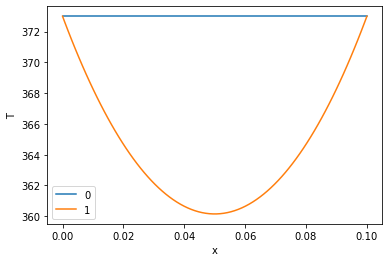

In [1322]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()


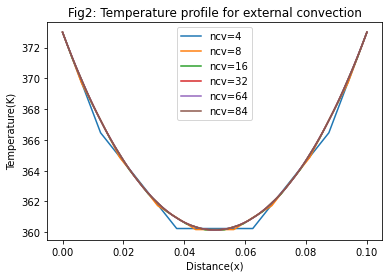

+-----+---------------------+----------------------+
| ncv | Average Temperature |  Difference in Temp  |
+-----+---------------------+----------------------+
|  4  |  366.5684647302904  |  366.5684647302904   |
|  8  |  365.8938181807584  |  0.6746465495319853  |
|  16 |  365.27723974926914 |  0.6165784314892448  |
|  32 |  364.8689619833984  | 0.40827776587076414  |
|  64 |  364.6344294739056  | 0.23453250949279436  |
|  84 |  364.57530445508144 | 0.059125018824147446 |
+-----+---------------------+----------------------+


In [1326]:
%matplotlib inline
import matplotlib.pyplot as plt

#Ploting all the curves for different ncv

plt.plot(xP1, T1, label='ncv=4')
plt.plot(xP2, T2, label='ncv=8')
plt.plot(xP3, T3, label='ncv=16')
plt.plot(xP4, T4, label='ncv=32')
plt.plot(xP5, T5, label='ncv=64')
plt.plot(xP6, T6, label='ncv=84')

plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()

#Display the title
plt.title('Fig2: Temperature profile for external convection')
plt.show()



from prettytable import PrettyTable
import random
    
x = PrettyTable()

x.field_names = ["ncv", "Average Temperature", "Difference in Temp"]

x.add_row([4, avg1, avg1])
x.add_row([8, avg2, -avg2+avg1])
x.add_row([16, avg3, -avg3+avg2])
x.add_row([32, avg4, -avg4+avg3])
x.add_row([64, avg5, -avg5+avg4])
x.add_row([84, avg6, -avg6+avg5])

print(x)

In [1317]:
#Grid Independe Test
'''
Figure 2 shows the different curves for ncv 4,8,16,32 and 64. 
The table above shows the difference in temperature from its previous ncv.
It can noted that the differnce is relatively lower for ncv 32,64 and 84.
For this problem ncv 64 can be selected as an appropriate grid.
'''


Average Temperature from the analytical solution is  364.47394121892177
Average Temperature from the Numerical Solution is 364.6344294739056


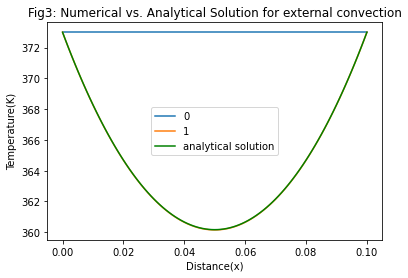

In [1332]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
#Comparison between analytical and numerical solution
#Numerical Solution
i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
#Analytical Solution
'''
m = sqrt(hp/kA)
h = convection coefficient = 12
k = thermal conductivity = 60
P = perimeter
Ac = Crosssectional Area
'''
m = 12.64 
L = 0.1
# 100 linearly spaced numbers
x = np.arange(0,0.101,.001)
#
R = ((1*(np.sinh(m*x))) + np.sinh(m*(L-x))) * (75 / np.sinh(m*L))
P = R + 298

#Display the avg temp for analytical solution
Avg_temp = np.mean(P)
print("Average Temperature from the analytical solution is ", Avg_temp)
#Display the avg temp for the numerical solution
print("Average Temperature from the Numerical Solution is", avg5)
plt.plot(x,P, 'g', label='analytical solution')
plt.xlabel("Distance(x)")
plt.ylabel("Temperature(K)")
plt.legend()
plt.title("Fig3: Numerical vs. Analytical Solution for external convection")
plt.show()



In [ ]:
#Comparison between the analytial and numerical solution
'''
Figure 3 shows the curves for both analytical and numerical solution.



In [ ]:
class RobinBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, T_inf, loc, ha, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            T_inf........ Ambient Temperature
            ha is the convective heat transfer coefficient
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._T_inf = T_inf
        self._ha = ha
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            return ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1 /(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")

In [ ]:
class HeatGenerationModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, q):
        """Constructor"""
        self._grid = grid

        self._q = q
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculating the source term SpVp with a negative sign to subtract it.
        source =  - self._q*self._grid.vol
        #print(source)
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [ ]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 64

grid = Grid(lx, ly, lz, ncv)


# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
ha = 280
q = 50000

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 320

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = RobinBc(T, grid, 323, BoundaryLocation.WEST, ha, k)
east_bc = RobinBc(T, grid, 313, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
HeatGeneration = HeatGenerationModel(grid, q)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = HeatGeneration.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1


T1 = 323
T2 = 313
L = 0.05
x = np.arange(-0.05, 0.051, .001)

P = ((12500/13)*(L**2 - x**2)) + ((T2-T1)*x*(7/2)) + (T1+T2)/2 + (125/14)
print(P)
#x = np.arange(0, 0.1, .001)
plt.plot(x, P, 'g', label = 'analytical solution')                              
'''
t = np.arange(-0.0182, 0.051, .001)
                              
Q = ((12500/13)*(L**2 - t**2)) + ((T2-T1)*t*(7/2)) + (T1+T2)/2 + (125/14)
print(Q)
plt.plot(t, Q, 'g', label='analytical soution')

'''
#print(P)


#plt.plot(x, P, 'g')
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [ ]:
# Problem 4
class SurfaceRadiationModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Tc, epi, sigma):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epi = epi
        self._Tc = Tc
        self._sigma = sigma
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = -self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)*self._grid.Ao
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [ ]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
h = 0
epi = 1
sigma = 5.67e-8
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [ ]:
# Problem 4(2)
class SurfaceRadiationModel2:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Tc, epi, sigma):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epi = epi
        self._Tc = Tc
        self._sigma = sigma
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epi*self._sigma*(self._T[1:-1]**4 - self._Tc**4)*self._grid.Ao
        
        # Calculate the linearization coefficients
        coeffP = self._epi*self._sigma*((self._T[1:-1])**3)*4*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [ ]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 0.1

# Define convection parameters
h = 0
epi = 1
sigma = 5.67e-8
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel2(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    #print(T)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()